<a href="https://colab.research.google.com/github/sm354/COL870-Assignment-2/blob/main/CGAN_mnist_maxout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from IPython import display
import torch.optim as optim

mnist = fetch_openml('mnist_784')
data_X = mnist.data
data_Y = mnist.target
data_Y=torch.from_numpy(data_Y.astype(int))
data_X=torch.from_numpy(data_X/255.)
print(data_X.shape, data_Y.shape, data_X.dtype, data_Y.dtype)

/usr/local/lib/python3.7/dist-packages/sklearn/datasets/_openml.py:55: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


torch.Size([70000, 784]) torch.Size([70000]) torch.float64 torch.int64


In [5]:
def sample_imgs(generator, device):
  with torch.no_grad():
    z=torch.rand(10,100).to(device)
    z_labels=torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
    x_fake=generator(z,z_labels)
  x_fake=x_fake.cpu().numpy()
  z_labels=z_labels.cpu().numpy()
  print(x_fake.shape,z_labels.shape)

  plt.figure(figsize=(15.,30.))
  for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.title(z_labels[ind])
    plt.imshow(x_fake[ind].reshape((28,28)),cmap='gray')
    plt.axis('off')
  plt.show()


In [26]:
class Maxout_layer(nn.Module):
    def __init__(self, input_dim=784, output_dim=240, pieces=5):
        super(Maxout_layer, self).__init__()
        self.params = torch.nn.ParameterList()
        self.fc_layers=[nn.Linear(in_features=input_dim,out_features=output_dim) for i in range(pieces)]
        for layer in self.fc_layers:
            self.params.extend(list(layer.parameters()))
        # self.params = torch.nn.ParameterList()
        # self.fc_layers = []
        # for layer in range(pieces):
        #     self.fc_layers.append(torch.nn.Linear(input_dim, output_dim))
        #     self.params.extend(list(self.fc_layers[layer].parameters()))

    def forward(self,inp): # inp.shape=batch_size,784
        op=[fc_layer.to(inp.device)(inp) for fc_layer in self.fc_layers] #op is [x1 ,x2 ...] xi is of size batchsize, 240
        op = torch.stack(op, dim = 0) #op now has shape 5, batchsize, 240
        op, _ = torch.max(op, dim = 0) #op now again has dimesnion batchsize, 240

        return op

# from torchsummary import summary

# maxout_layer = Maxout_layer()
# summary(maxout_layer, (1, 784))

In [33]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_labels=10, output_dim=784):
        super(Generator, self).__init__()
        self.latent_dim=latent_dim
        self.num_labels=num_labels
        self.output_dim=output_dim
        
        self.embedding=torch.tensor(np.eye(self.num_labels)).float()
        
        self.dp1=nn.Dropout(0.5)
        self.fc1=nn.Linear(in_features=100,out_features=200)
        self.dp2=nn.Dropout(0.5)
        self.fc2=nn.Linear(in_features=10,out_features=1000)
        self.dp3=nn.Dropout(0.5)
        self.fc3=nn.Linear(in_features=1200,out_features=784)
                
    def forward(self,z,y): # z:batch_size,100; y:batch_size,
        # z=self.dp1(z)
        op1=self.dp2(F.relu(self.fc1(z)))
        y_1hot=self.embedding.to(z.device)[y]
        op2=self.dp3(F.relu(self.fc2(y_1hot)))
        op=torch.cat((op1,op2),dim=-1) #batch_size,1200
        op=torch.sigmoid(self.fc3(op))  
        return op


class Discriminator(nn.Module):
    def __init__(self, input_dim=784, num_labels=10, output_dim=1):
        super(Discriminator, self).__init__()
        self.input_dim=input_dim
        self.num_labels=num_labels
        self.output_dim=output_dim
        
        self.embedding=torch.tensor(np.eye(self.num_labels)).float()
        
        self.dp0=nn.Dropout(0.5)
        self.max1=Maxout_layer(input_dim=input_dim, output_dim=240, pieces=5) #nn.Linear(input_dim, 240)#
        self.dp1=nn.Dropout(0.5)
        self.max2=Maxout_layer(input_dim=10, output_dim=50, pieces=5) #nn.Linear(10, 50)#
        self.dp2=nn.Dropout(0.5)
        self.max3=Maxout_layer(input_dim=290, output_dim=240, pieces=4) #nn.Linear(290, 240)#
        self.dp3=nn.Dropout(0.5)
        self.fc=nn.Linear(in_features=240, out_features=1)
    
    def forward(self,x,y): # x:batch_size,784; y:batch_size,
        x=self.dp0(x)
        op1=self.dp1(F.relu(self.max1(x)))
        y_1hot=self.embedding.to(y.device)[y]
        op2=self.dp2(F.relu(self.max2(y_1hot)))
        op=torch.cat((op1,op2),dim=-1)
        op=self.dp3(F.relu(self.max3(op)))
        op=torch.sigmoid(self.fc(op))
        return op


In [34]:
dataset=TensorDataset(data_X,data_Y)
data_loader=DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

discriminator=Discriminator(input_dim=784, num_labels=10, output_dim=1)
generator=Generator(latent_dim=100, num_labels=10, output_dim=784)

loss_fn=nn.BCELoss() # or may use MSE
optim_disc=optim.SGD(discriminator.parameters(),lr=0.1,momentum=0.5)
scheduler_disc=optim.lr_scheduler.ExponentialLR(optim_disc, 1/1.00004, verbose=True)
optim_gen=optim.SGD(generator.parameters(),lr=0.1,momentum=0.5)
scheduler_gen=optim.lr_scheduler.ExponentialLR(optim_gen, 1/1.00004)

device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

generator=generator.to(device)
discriminator=discriminator.to(device)

Adjusting learning rate of group 0 to 1.0000e-01.
cuda


(10, 784) (10,)


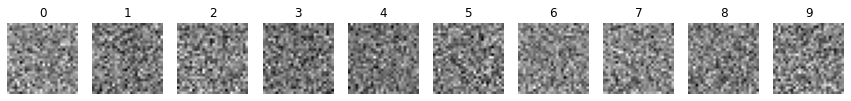

Original Real images


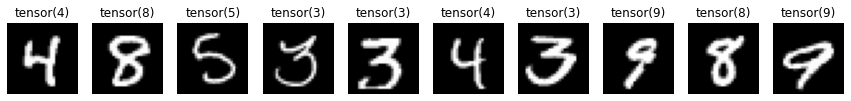

Adjusting learning rate of group 0 to 9.9996e-02.
epoch: 0 discriminator loss: 0.14753681089005846 generator loss: 5.798128320402278
Adjusting learning rate of group 0 to 9.9992e-02.
epoch: 1 discriminator loss: 0.15902303035060564 generator loss: 4.099734805442474
Adjusting learning rate of group 0 to 9.9988e-02.
epoch: 2 discriminator loss: 0.16780506782643087 generator loss: 3.825257577738919
Adjusting learning rate of group 0 to 9.9984e-02.
epoch: 3 discriminator loss: 0.22250045492098883 generator loss: 3.2198843082665523
Adjusting learning rate of group 0 to 9.9980e-02.
epoch: 4 discriminator loss: 0.18738007215243993 generator loss: 3.508473025573479
(10, 784) (10,)


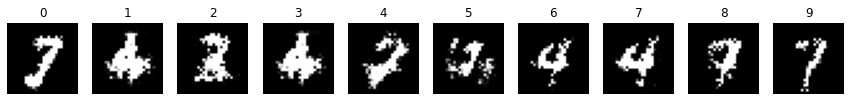

Adjusting learning rate of group 0 to 9.9976e-02.
epoch: 5 discriminator loss: 0.15931737645368874 generator loss: 4.1193136518254825
Adjusting learning rate of group 0 to 9.9972e-02.
epoch: 6 discriminator loss: 0.15138615946193318 generator loss: 4.449364150836791
Adjusting learning rate of group 0 to 9.9968e-02.
epoch: 7 discriminator loss: 0.16012770125826636 generator loss: 4.4581456415819165
Adjusting learning rate of group 0 to 9.9964e-02.
epoch: 8 discriminator loss: 0.1711389609772862 generator loss: 4.141321657341479
Adjusting learning rate of group 0 to 9.9960e-02.
epoch: 9 discriminator loss: 0.15926901238796476 generator loss: 4.248281547438094
(10, 784) (10,)


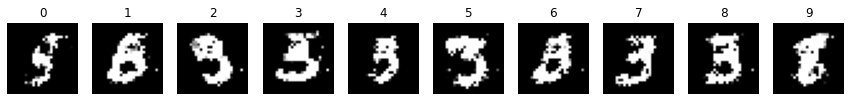

Adjusting learning rate of group 0 to 9.9956e-02.
epoch: 10 discriminator loss: 0.14273204402008774 generator loss: 4.58446174576169
Adjusting learning rate of group 0 to 9.9952e-02.
epoch: 11 discriminator loss: 0.13362515234685207 generator loss: 4.810423790316879
Adjusting learning rate of group 0 to 9.9948e-02.
epoch: 12 discriminator loss: 0.1522614865021391 generator loss: 4.594351217860267
Adjusting learning rate of group 0 to 9.9944e-02.
epoch: 13 discriminator loss: 0.17650261646880336 generator loss: 4.095606528359019
Adjusting learning rate of group 0 to 9.9940e-02.
epoch: 14 discriminator loss: 0.18280072996031232 generator loss: 3.8173845552262806
(10, 784) (10,)


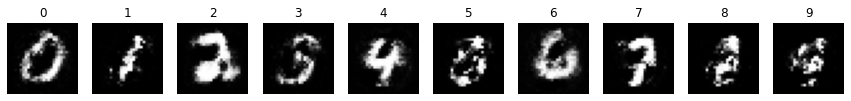

Adjusting learning rate of group 0 to 9.9936e-02.
epoch: 15 discriminator loss: 0.2194614568145284 generator loss: 3.089641492008726
Adjusting learning rate of group 0 to 9.9932e-02.
epoch: 16 discriminator loss: 0.2605852530552791 generator loss: 2.7514706500720627
Adjusting learning rate of group 0 to 9.9928e-02.
epoch: 17 discriminator loss: 0.2731186304336939 generator loss: 2.5181292640420545
Adjusting learning rate of group 0 to 9.9924e-02.
epoch: 18 discriminator loss: 0.2722991608055957 generator loss: 2.5107991381005927
Adjusting learning rate of group 0 to 9.9920e-02.
epoch: 19 discriminator loss: 0.2673528007480688 generator loss: 2.544696236268068
(10, 784) (10,)


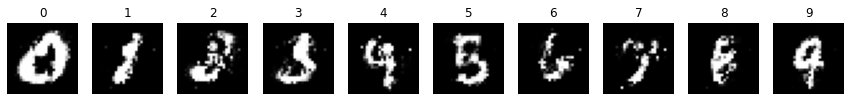

Adjusting learning rate of group 0 to 9.9916e-02.
epoch: 20 discriminator loss: 0.25842412978738216 generator loss: 2.642781768089686
Adjusting learning rate of group 0 to 9.9912e-02.
epoch: 21 discriminator loss: 0.2500978305717528 generator loss: 2.70311618462587
Adjusting learning rate of group 0 to 9.9908e-02.
epoch: 22 discriminator loss: 0.2484893933648155 generator loss: 2.7120782813746414
Adjusting learning rate of group 0 to 9.9904e-02.
epoch: 23 discriminator loss: 0.23553920670961723 generator loss: 2.8138422110141854
Adjusting learning rate of group 0 to 9.9900e-02.
epoch: 24 discriminator loss: 0.2331387078587389 generator loss: 2.8679283542947456
(10, 784) (10,)


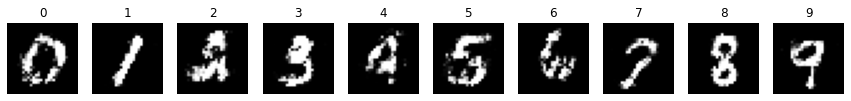

Adjusting learning rate of group 0 to 9.9896e-02.
epoch: 25 discriminator loss: 0.23567391675470512 generator loss: 2.8448878273422467
Adjusting learning rate of group 0 to 9.9892e-02.
epoch: 26 discriminator loss: 0.2512478026059958 generator loss: 2.784514675646911
Adjusting learning rate of group 0 to 9.9888e-02.
epoch: 27 discriminator loss: 0.24934363004925486 generator loss: 2.734604138594407
Adjusting learning rate of group 0 to 9.9884e-02.
epoch: 28 discriminator loss: 0.24757064384964358 generator loss: 2.742990026107201
Adjusting learning rate of group 0 to 9.9880e-02.
epoch: 29 discriminator loss: 0.24100972823935113 generator loss: 2.7929318160801144
(10, 784) (10,)


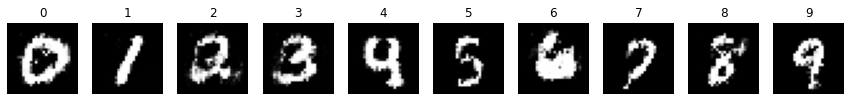

Adjusting learning rate of group 0 to 9.9876e-02.
epoch: 30 discriminator loss: 0.23729775906045794 generator loss: 2.850741704741677
Adjusting learning rate of group 0 to 9.9872e-02.
epoch: 31 discriminator loss: 0.23628094762345372 generator loss: 2.8459675923371925
Adjusting learning rate of group 0 to 9.9868e-02.
epoch: 32 discriminator loss: 0.2368095835923275 generator loss: 2.837408258801415
Adjusting learning rate of group 0 to 9.9864e-02.
epoch: 33 discriminator loss: 0.2354411292316276 generator loss: 2.8035054219948066
Adjusting learning rate of group 0 to 9.9860e-02.
epoch: 34 discriminator loss: 0.23880487110042747 generator loss: 2.8108341637111844
(10, 784) (10,)


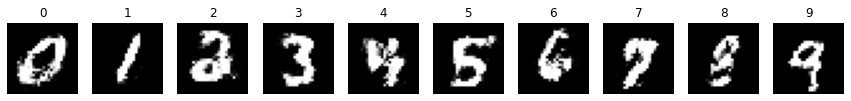

Adjusting learning rate of group 0 to 9.9856e-02.
epoch: 35 discriminator loss: 0.2475160478235601 generator loss: 2.7673693624608244
Adjusting learning rate of group 0 to 9.9852e-02.
epoch: 36 discriminator loss: 0.24809543933078046 generator loss: 2.757008513688168
Adjusting learning rate of group 0 to 9.9848e-02.
epoch: 37 discriminator loss: 0.2541688010915295 generator loss: 2.72642949561933
Adjusting learning rate of group 0 to 9.9844e-02.
epoch: 38 discriminator loss: 0.2654249159407703 generator loss: 2.623755770725208
Adjusting learning rate of group 0 to 9.9840e-02.
epoch: 39 discriminator loss: 0.2770883797671332 generator loss: 2.522840921695416
(10, 784) (10,)


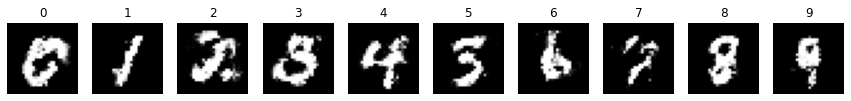

Adjusting learning rate of group 0 to 9.9836e-02.
epoch: 40 discriminator loss: 0.2819276851612133 generator loss: 2.472369406467829
Adjusting learning rate of group 0 to 9.9832e-02.
epoch: 41 discriminator loss: 0.2893378735953198 generator loss: 2.4136973468811957
Adjusting learning rate of group 0 to 9.9828e-02.
epoch: 42 discriminator loss: 0.2936356884492186 generator loss: 2.367337412886567
Adjusting learning rate of group 0 to 9.9824e-02.
epoch: 43 discriminator loss: 0.29907194328504605 generator loss: 2.3591837269482596
Adjusting learning rate of group 0 to 9.9820e-02.
epoch: 44 discriminator loss: 0.3059992518944618 generator loss: 2.279927623577607
(10, 784) (10,)


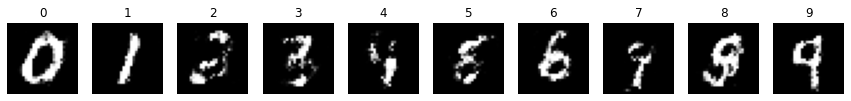

Adjusting learning rate of group 0 to 9.9816e-02.
epoch: 45 discriminator loss: 0.3060747974794426 generator loss: 2.2868083673955755
Adjusting learning rate of group 0 to 9.9812e-02.
epoch: 46 discriminator loss: 0.31058191603574997 generator loss: 2.2534449510958607
Adjusting learning rate of group 0 to 9.9808e-02.
epoch: 47 discriminator loss: 0.3158750798785206 generator loss: 2.2295832625238887
Adjusting learning rate of group 0 to 9.9804e-02.
epoch: 48 discriminator loss: 0.3164448293792459 generator loss: 2.1999389361112547
Adjusting learning rate of group 0 to 9.9800e-02.
epoch: 49 discriminator loss: 0.323467795310658 generator loss: 2.158896280295683
(10, 784) (10,)


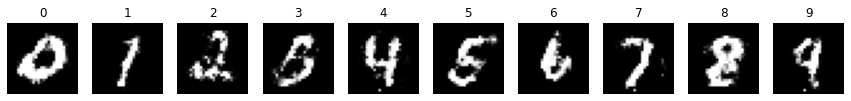

Adjusting learning rate of group 0 to 9.9796e-02.
epoch: 50 discriminator loss: 0.3240924990111655 generator loss: 2.146124794587984
Adjusting learning rate of group 0 to 9.9792e-02.
epoch: 51 discriminator loss: 0.3294321488002281 generator loss: 2.1340191931951615
Adjusting learning rate of group 0 to 9.9788e-02.
epoch: 52 discriminator loss: 0.33019255071660103 generator loss: 2.11156320419067
Adjusting learning rate of group 0 to 9.9784e-02.
epoch: 53 discriminator loss: 0.34245410345958704 generator loss: 2.046165086410858
Adjusting learning rate of group 0 to 9.9780e-02.
epoch: 54 discriminator loss: 0.3498596361541486 generator loss: 1.993990108862028
(10, 784) (10,)


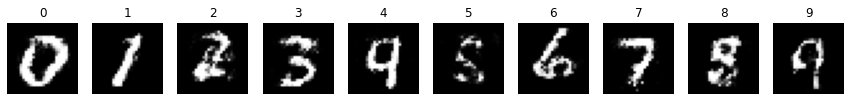

Adjusting learning rate of group 0 to 9.9776e-02.
epoch: 55 discriminator loss: 0.3443949791319641 generator loss: 2.0221697757968973
Adjusting learning rate of group 0 to 9.9772e-02.
epoch: 56 discriminator loss: 0.3475788371030228 generator loss: 2.0154770272118703
Adjusting learning rate of group 0 to 9.9768e-02.
epoch: 57 discriminator loss: 0.3505017910248194 generator loss: 1.9879284173577696
Adjusting learning rate of group 0 to 9.9764e-02.
epoch: 58 discriminator loss: 0.3538923136098481 generator loss: 1.9645424775588207
Adjusting learning rate of group 0 to 9.9760e-02.
epoch: 59 discriminator loss: 0.35532075808052616 generator loss: 1.9425861494881767
(10, 784) (10,)


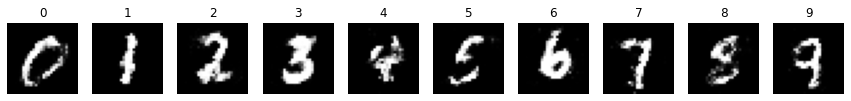

Adjusting learning rate of group 0 to 9.9756e-02.
epoch: 60 discriminator loss: 0.3566184102288096 generator loss: 1.9340518852729938
Adjusting learning rate of group 0 to 9.9752e-02.
epoch: 61 discriminator loss: 0.3617479766244853 generator loss: 1.920148111525036
Adjusting learning rate of group 0 to 9.9748e-02.
epoch: 62 discriminator loss: 0.3641489037336447 generator loss: 1.8911053132224869
Adjusting learning rate of group 0 to 9.9744e-02.
epoch: 63 discriminator loss: 0.365940680761477 generator loss: 1.8816884742988336
Adjusting learning rate of group 0 to 9.9740e-02.
epoch: 64 discriminator loss: 0.37222943763374844 generator loss: 1.8518820859137035
(10, 784) (10,)


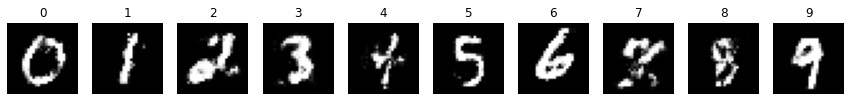

Adjusting learning rate of group 0 to 9.9736e-02.
epoch: 65 discriminator loss: 0.37069353723264004 generator loss: 1.8653339060234937
Adjusting learning rate of group 0 to 9.9732e-02.
epoch: 66 discriminator loss: 0.37292022162523025 generator loss: 1.8528232760045118
Adjusting learning rate of group 0 to 9.9728e-02.
epoch: 67 discriminator loss: 0.37208043672007957 generator loss: 1.8466947484802414
Adjusting learning rate of group 0 to 9.9724e-02.
epoch: 68 discriminator loss: 0.3783535812691454 generator loss: 1.8239550985696116
Adjusting learning rate of group 0 to 9.9720e-02.
epoch: 69 discriminator loss: 0.3792771051873218 generator loss: 1.8143550100780668
(10, 784) (10,)


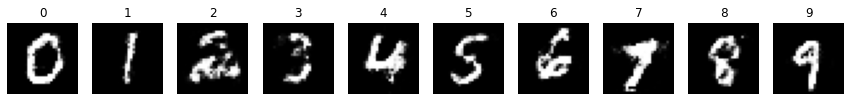

Adjusting learning rate of group 0 to 9.9716e-02.
epoch: 70 discriminator loss: 0.3806425533888541 generator loss: 1.8049156657068721
Adjusting learning rate of group 0 to 9.9712e-02.
epoch: 71 discriminator loss: 0.3787620037575781 generator loss: 1.8196478584310511
Adjusting learning rate of group 0 to 9.9708e-02.
epoch: 72 discriminator loss: 0.3823836004777706 generator loss: 1.7987934896797488
Adjusting learning rate of group 0 to 9.9704e-02.
epoch: 73 discriminator loss: 0.3846003954117988 generator loss: 1.788728382779565
Adjusting learning rate of group 0 to 9.9700e-02.
epoch: 74 discriminator loss: 0.38578131101725305 generator loss: 1.7844451124414855
(10, 784) (10,)


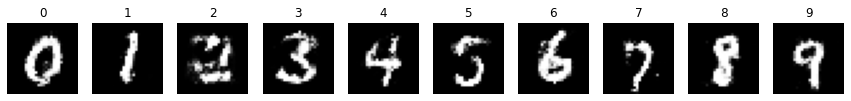

Adjusting learning rate of group 0 to 9.9696e-02.
epoch: 75 discriminator loss: 0.38949364745791576 generator loss: 1.7458095404254648
Adjusting learning rate of group 0 to 9.9692e-02.
epoch: 76 discriminator loss: 0.389510283212522 generator loss: 1.7520916765426104
Adjusting learning rate of group 0 to 9.9688e-02.
epoch: 77 discriminator loss: 0.38831920785345003 generator loss: 1.7536060345041884
Adjusting learning rate of group 0 to 9.9685e-02.
epoch: 78 discriminator loss: 0.3919728668508949 generator loss: 1.7436998128454326
Adjusting learning rate of group 0 to 9.9681e-02.
epoch: 79 discriminator loss: 0.39239472691174393 generator loss: 1.7381943748110817
(10, 784) (10,)


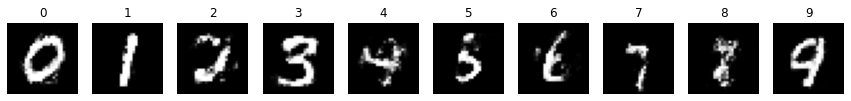

Adjusting learning rate of group 0 to 9.9677e-02.
epoch: 80 discriminator loss: 0.3954543023209869 generator loss: 1.7267713376453944
Adjusting learning rate of group 0 to 9.9673e-02.
epoch: 81 discriminator loss: 0.39313829223533253 generator loss: 1.7298866027877444
Adjusting learning rate of group 0 to 9.9669e-02.
epoch: 82 discriminator loss: 0.3974058415754374 generator loss: 1.7066736642694298
Adjusting learning rate of group 0 to 9.9665e-02.
epoch: 83 discriminator loss: 0.398569575159541 generator loss: 1.7063611066821731
Adjusting learning rate of group 0 to 9.9661e-02.
epoch: 84 discriminator loss: 0.3943594289131654 generator loss: 1.7175162495710912
(10, 784) (10,)


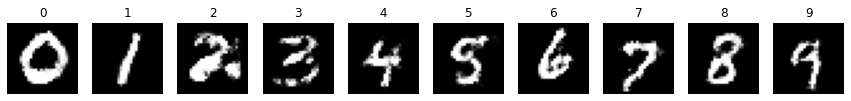

Adjusting learning rate of group 0 to 9.9657e-02.
epoch: 85 discriminator loss: 0.3965620615215965 generator loss: 1.7120896276536879
Adjusting learning rate of group 0 to 9.9653e-02.
epoch: 86 discriminator loss: 0.3977927620157654 generator loss: 1.7111566479389484
Adjusting learning rate of group 0 to 9.9649e-02.
epoch: 87 discriminator loss: 0.3989785731166274 generator loss: 1.6933720688243488
Adjusting learning rate of group 0 to 9.9645e-02.
epoch: 88 discriminator loss: 0.4023735089834793 generator loss: 1.680569515123472
Adjusting learning rate of group 0 to 9.9641e-02.
epoch: 89 discriminator loss: 0.4028702151207697 generator loss: 1.6810773375270132
(10, 784) (10,)


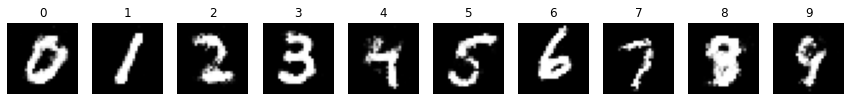

Adjusting learning rate of group 0 to 9.9637e-02.
epoch: 90 discriminator loss: 0.4005729327926706 generator loss: 1.6866847556152624
Adjusting learning rate of group 0 to 9.9633e-02.
epoch: 91 discriminator loss: 0.401521894575912 generator loss: 1.6947423258980552
Adjusting learning rate of group 0 to 9.9629e-02.
epoch: 92 discriminator loss: 0.40491039483320146 generator loss: 1.6676051099221785
Adjusting learning rate of group 0 to 9.9625e-02.
epoch: 93 discriminator loss: 0.4041035042140947 generator loss: 1.6649906971515753
Adjusting learning rate of group 0 to 9.9621e-02.
epoch: 94 discriminator loss: 0.4044884211851127 generator loss: 1.669271116728311
(10, 784) (10,)


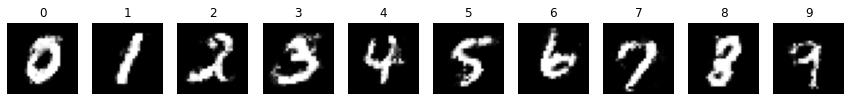

Adjusting learning rate of group 0 to 9.9617e-02.
epoch: 95 discriminator loss: 0.4046182197965545 generator loss: 1.677101024777898
Adjusting learning rate of group 0 to 9.9613e-02.
epoch: 96 discriminator loss: 0.4053794142309126 generator loss: 1.6685361174436717
Adjusting learning rate of group 0 to 9.9609e-02.
epoch: 97 discriminator loss: 0.40746787588893274 generator loss: 1.6614405440760183
Adjusting learning rate of group 0 to 9.9605e-02.
epoch: 98 discriminator loss: 0.40601058801015216 generator loss: 1.6651970689549989
Adjusting learning rate of group 0 to 9.9601e-02.
epoch: 99 discriminator loss: 0.4255417114867395 generator loss: 1.626580372398153


In [35]:

num_epochs=100
for ep in range(num_epochs):
    disc_loss,gen_loss=0,0
    if ep%5==0:
        sample_imgs(generator, device)

    for batch, (X,Y) in enumerate(data_loader):
        # if batch%100==0:
          # print(batch,end='\r')
          # display.clear_output(wait=True)
        if batch==0 and ep==0:
            print("Original Real images")
            plt.figure(figsize=(15.,30.))
            for ind in range(10):
                plt.subplot(1,10,ind+1)
                plt.title(Y[ind])
                plt.imshow(X[ind].reshape((28,28)),cmap='gray')
                plt.axis('off')
            plt.show()
        
        X,Y = X.to(device).float(), Y.to(device)

        z=torch.rand(X.shape[0],100).to(device)
        z_labels=torch.randint(low=0,high=10,size=(X.shape[0],)).to(device)

        # train the discriminator
        optim_disc.zero_grad()
        y_real=torch.ones(X.shape[0],1).to(device)
        y_pred_real=discriminator(X,Y.long())
        y_fake=torch.zeros(X.shape[0],1).to(device)
        
        X_fake=generator(z,z_labels)
        y_pred_fake=discriminator(X_fake,z_labels)
        loss1=loss_fn(y_pred_real,y_real)
        loss2=loss_fn(y_pred_fake,y_fake)
        loss=(loss1+loss2)/2
        disc_loss+=loss.item()
        loss.backward()
        optim_disc.step()
        

        # train the generator
        optim_gen.zero_grad()
        y_fool=torch.ones(X.shape[0],1).to(device)
        x_fake=generator(z,z_labels)
        y_pred=discriminator(x_fake,z_labels)
        loss=loss_fn(y_pred,y_fool)
        gen_loss+=loss.item()
        loss.backward()
        optim_gen.step()
        
    scheduler_disc.step()
    scheduler_gen.step()

    print("epoch:",ep,"discriminator loss:",disc_loss/batch,"generator loss:",gen_loss/batch)

(10, 784) (10,)


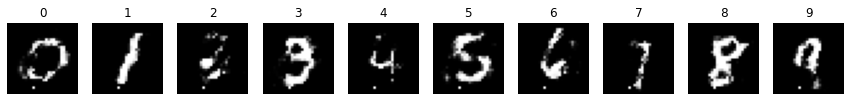

(10, 784) (10,)


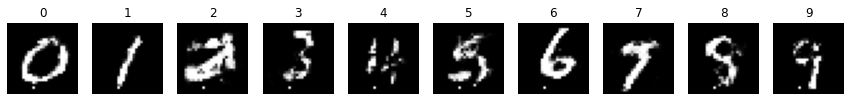

(10, 784) (10,)


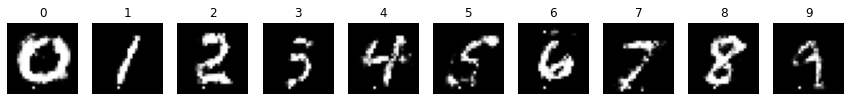

(10, 784) (10,)


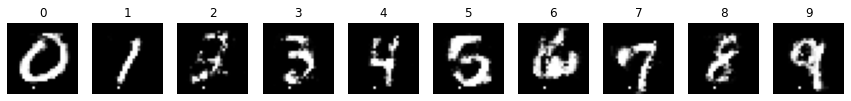

(10, 784) (10,)


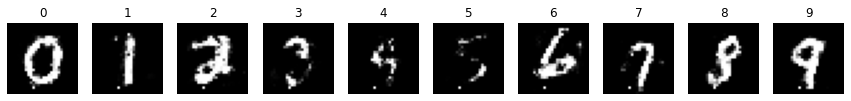

(10, 784) (10,)


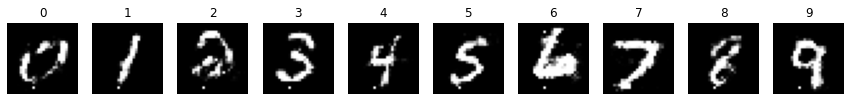

(10, 784) (10,)


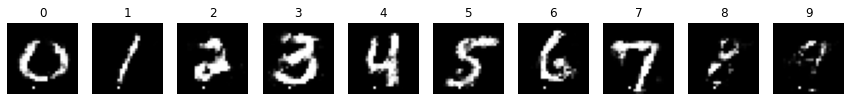

(10, 784) (10,)


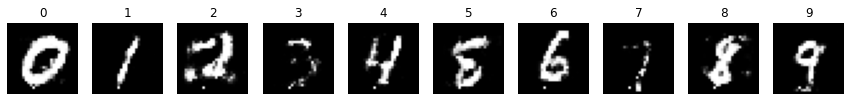

(10, 784) (10,)


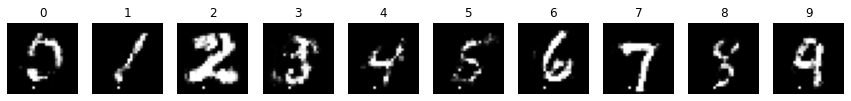

(10, 784) (10,)


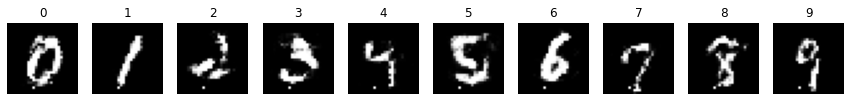

In [36]:
for i in range(10):
  sample_imgs(generator, device)